## Run multiple frameworks with Appose

Call multiple deep learning frameworks (cellpose cyto3, cellposesam, microsam, and mobilesam) in the same notebook


In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_path = r"D:\images\tnia-python-images\imagesc\2024_03_27_SOTA_segmentation\images\cell_00081.bmp"
label_path = r"D:\images\tnia-python-images\imagesc\2024_03_27_SOTA_segmentation\labels\cell_00081_label.tiff"

cell_00081
Loaded image shape: (1920, 2560, 3), dtype: uint8


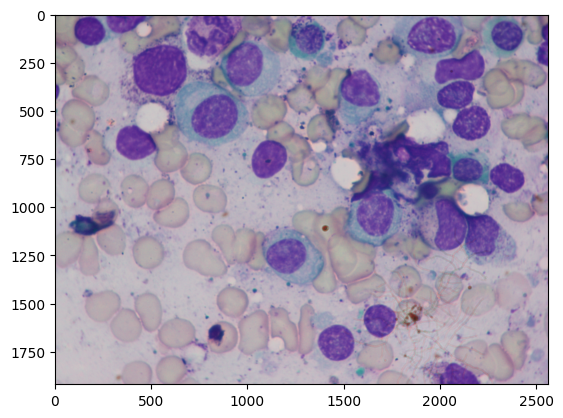

In [3]:

image_name = os.path.basename(image_path)
image_name = os.path.splitext(image_name)[0]
print(image_name)

img = io.imread(image_path)

if (len(img.shape) == 2):
    img = np.expand_dims(img, axis=2)  # Add channel dimension if it's grayscale
    # repeat channels so there is 3
    img = np.repeat(img, 3, axis=2)

# Print image information
print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")

plt.imshow(img)

In [4]:
from napari_ai_lab.Segmenters.GlobalSegmenters.CellposeSegmenter import CellposeSegmenter
from napari_ai_lab.Segmenters.execute_appose import execute_appose


In [5]:
# Simple cellpose configuration
segmenter = CellposeSegmenter(model_type="cyto2", diameter=30, use_gpu=False)

run_in_local_environment = segmenter.are_dependencies_available()

print(f"🔍 Cellpose local: {'✅ Available' if run_in_local_environment else '❌ Not found'}")
    

🔍 Cellpose local: ❌ Not found


Cellpose not available locally - generated execution string for remote processing
This string can be sent to a cellpose-enabled environment for execution
dict_keys(['mask'])


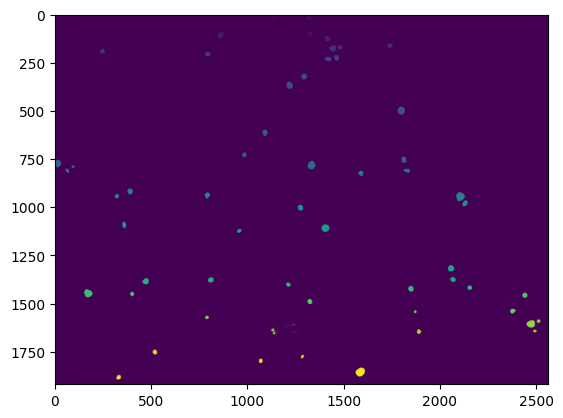

In [21]:
cellpose_env_path = r"C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\pixi\microsam_cellpose3\.pixi\envs\default"

result = execute_appose(img, segmenter, cellpose_env_path)

plt.imshow(result.ndarray())

In [18]:
import appose

additional_inputs = None

execution_string = segmenter.get_execution_string(img)

env = appose.base(cellpose_env_path).build()
ndarr_img = appose.NDArray(dtype=str(img.dtype), shape=img.shape)
ndarr_img.ndarray()[:] = img

# Always include image, optionally add additional inputs
inputs = {"image": ndarr_img}
if additional_inputs is not None:
    inputs.update(additional_inputs)

with env.python() as python:
    print('run task')
    task = python.task(execution_string, inputs=inputs, queue="main")
    task.wait_for()

    if task.error:
        print(f"⚠️  Task error: {task.error}")

    print('hello finished')
    print(task.outputs.keys())

    result = task.outputs.get("mask", None)
    


Cellpose not available locally - generated execution string for remote processing
This string can be sent to a cellpose-enabled environment for execution
run task
hello finished
dict_keys(['mask'])


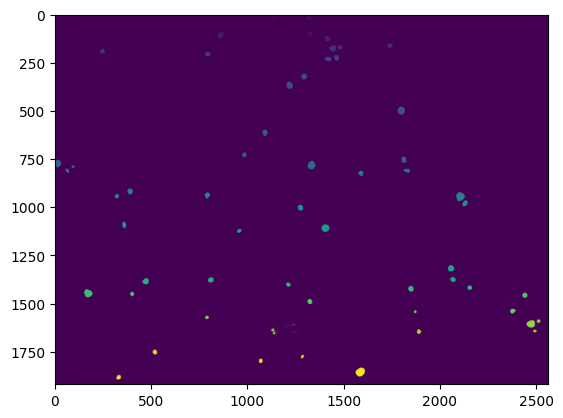

In [20]:
plt.imshow(result.ndarray())

In [16]:
print(execution_string)


import numpy as np
import cellpose
from cellpose import models

# Parameters from segmenter
model_type = "cyto2"
use_gpu = False
diameter = 30
flow_threshold = 0.4
cellpose_iterations = 200

# Image will be provided as 'image' variable
# image.shape = (1920, 2560, 3)
# image.dtype = uint8

def cellpose_segment_remote(image):
    """Remote cellpose segmentation function."""

    # Get cellpose version and create appropriate model
    major_number = cellpose.version.split('.')[0]
    print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

    try:
        if major_number == '4':
            model = models.CellposeModel(gpu=use_gpu, model_type=model_type)
        else:
            # For version 3 and all other versions, use the older API
            model = models.Cellpose(gpu=use_gpu, model_type=model_type)

        print(f"Created Cellpose model: {model_type}, GPU: {use_gpu}")

    except Exception as e:
        print(f"Error creating Cellpose model: {e}")
      